# ONNX ResNet Model

This example will show inference over an exported [ONNX](https://github.com/onnx/onnx) ResNet model using Seldon Core. We will use the Seldon S2I wrapper for Intel's NGraph. The example follows this [NGraph tutorial](https://ai.intel.com/adaptable-deep-learning-solutions-with-ngraph-compiler-and-onnx/).

 Prerequisites:
   * ```pip install seldon-core```
   * To test locally [ngraph installed](https://github.com/NervanaSystems/ngraph-onnx)
   * protoc > 3.4.0
   
To run all of the notebook successfully you will need to start it with
```
jupyter notebook --NotebookApp.iopub_data_rate_limit=100000000
```

Download ResNet model fron ONNX Zoo.

In [1]:
!wget https://s3.amazonaws.com/download.onnx/models/opset_8/resnet50.tar.gz
!tar -xzvf resnet50.tar.gz
!rm resnet50.tar.gz

--2019-04-24 15:34:51--  https://s3.amazonaws.com/download.onnx/models/opset_8/resnet50.tar.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.160.221
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.160.221|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 101706397 (97M) [binary/octet-stream]
Saving to: ‘resnet50.tar.gz’

resnet50.tar.gz     100%[===================>]  96.99M  8.23MB/s    in 25s     

2019-04-24 15:35:16 (3.90 MB/s) - ‘resnet50.tar.gz’ saved [101706397/101706397]

resnet50/
resnet50/test_data_0.npz
resnet50/test_data_2.npz
resnet50/test_data_1.npz
resnet50/test_data_set_0/
resnet50/test_data_set_0/input_0.pb
resnet50/test_data_set_0/output_0.pb
resnet50/test_data_set_1/
resnet50/test_data_set_1/input_0.pb
resnet50/test_data_set_1/output_0.pb
resnet50/test_data_set_2/
resnet50/test_data_set_2/input_0.pb
resnet50/test_data_set_2/output_0.pb
resnet50/test_data_set_3/
resnet50/test_data_set_3/input_0.pb
resnet50/test_data_set_3/out

In [2]:
%matplotlib inline
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
import ngraph as ng
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Test Model
Load ONNX model into ngraph.

In [3]:
from ngraph_onnx.onnx_importer.importer import import_onnx_file

# Import the ONNX file
models = import_onnx_file('resnet50/model.onnx')

# Create an nGraph runtime environment
runtime = ng.runtime(backend_name='CPU')

# Select the first model and compile it to a callable function
model = models[0]
resnet = runtime.computation(model['output'], *model['inputs'])


ONNX `ai.onnx` opset version 8 is not supported. Falling back to latest supported version: 7
More than one different shape in input nodes [<Constant: 'Constant_289' ([])>, <BatchNormInference: 'gpu_0/res2_0_branch2c_bn_1' ([1, 256, 56, 56])>].
More than one different shape in input nodes [<Constant: 'Constant_308' ([])>, <BatchNormInference: 'gpu_0/res2_1_branch2c_bn_1' ([1, 256, 56, 56])>].
More than one different shape in input nodes [<Constant: 'Constant_327' ([])>, <BatchNormInference: 'gpu_0/res2_2_branch2c_bn_1' ([1, 256, 56, 56])>].
More than one different shape in input nodes [<Constant: 'Constant_349' ([])>, <BatchNormInference: 'gpu_0/res3_0_branch2c_bn_1' ([1, 512, 28, 28])>].
More than one different shape in input nodes [<Constant: 'Constant_368' ([])>, <BatchNormInference: 'gpu_0/res3_1_branch2c_bn_1' ([1, 512, 28, 28])>].
More than one different shape in input nodes [<Constant: 'Constant_387' ([])>, <BatchNormInference: 'gpu_0/res3_2_branch2c_bn_1' ([1, 512, 28, 28])>].
M

Test on an image of a Zebra.

[[('n02391049', 'zebra', 0.99543387),
  ('n02423022', 'gazelle', 0.0006074826),
  ('n01518878', 'ostrich', 0.0005718305),
  ('n02422106', 'hartebeest', 0.00048323255),
  ('n02422699', 'impala', 0.0003381068)]]

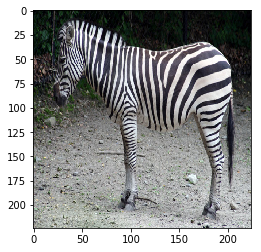

In [4]:
img = image.load_img('zebra.jpg', target_size=(224, 224))
img = image.img_to_array(img)
plt.imshow(img / 255.)
x = np.expand_dims(img.copy(), axis=0)
x = preprocess_input(x,mode='torch')
x = x.transpose(0,3,1,2)
preds = resnet(x)
decode_predictions(preds[0], top=5)

## Package Model Using S2I

In [5]:
!s2i build . seldonio/seldon-core-s2i-python3-ngraph-onnx:0.3 onnx-resnet:0.1

---> Installing application source...
---> Installing dependencies ...
Running setup.py bdist_wheel for pyyaml: started
Running setup.py bdist_wheel for pyyaml: finished with status 'done'
Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
You are using pip version 18.1, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Build completed successfully


In [6]:
!docker run --name "onnx_resnet_predictor" -d --rm -p 5000:5000 onnx-resnet:0.1

2cb7af654473d83aadacbcf4167271161a81cbba6d7919d8f42f3b724974312a


In [8]:
!seldon-core-tester contract.json 0.0.0.0 5000 -p

----------------------------------------
SENDING NEW REQUEST:

[[[[0.888 0.714 0.452 ... 0.64  0.367 0.288]
   [0.981 0.44  0.077 ... 0.636 0.331 0.513]
   [0.613 0.36  0.413 ... 0.418 0.669 0.955]
   ...
   [0.604 0.321 0.569 ... 0.789 0.239 0.127]
   [0.081 0.786 0.974 ... 0.364 0.595 0.149]
   [0.037 0.486 0.697 ... 0.353 0.884 0.221]]

  [[0.237 0.926 0.605 ... 0.461 0.767 0.483]
   [0.527 0.894 0.212 ... 0.443 0.285 0.409]
   [0.983 0.521 0.208 ... 0.693 0.671 0.683]
   ...
   [0.333 0.45  0.674 ... 0.361 0.506 0.067]
   [0.385 0.096 0.811 ... 0.464 0.023 0.869]
   [0.318 0.46  0.452 ... 0.806 0.769 0.316]]

  [[0.633 0.982 0.495 ... 0.928 0.775 0.81 ]
   [0.54  0.098 0.56  ... 0.409 0.621 0.758]
   [0.959 0.571 0.152 ... 0.432 0.323 0.596]
   ...
   [0.159 0.469 0.975 ... 0.165 0.135 0.312]
   [0.685 0.859 0.111 ... 0.382 0.943 0.715]
   [0.165 0.453 0.042 ... 0.032 0.666 0.48 ]]]]
RECEIVED RESPONSE:
meta {
}
data {
  names: "t:0"
  ndarray {
    values {
      list_value {
     

In [9]:
!docker rm onnx_resnet_predictor --force

onnx_resnet_predictor


## Test using Minikube

**Due to a [minikube/s2i issue](https://github.com/SeldonIO/seldon-core/issues/253) you will need [s2i >= 1.1.13](https://github.com/openshift/source-to-image/releases/tag/v1.1.13)**

In [5]:
!minikube start --memory 4096

😄  minikube v0.34.1 on linux (amd64)
🔥  Creating virtualbox VM (CPUs=2, Memory=4096MB, Disk=20000MB) ...
📶  "minikube" IP address is 192.168.99.100
🐳  Configuring Docker as the container runtime ...
✨  Preparing Kubernetes environment ...
🚜  Pulling images required by Kubernetes v1.13.3 ...
🚀  Launching Kubernetes v1.13.3 using kubeadm ... 
🔑  Configuring cluster permissions ...
🤔  Verifying component health .....
💗  kubectl is now configured to use "minikube"
🏄  Done! Thank you for using minikube!


## Setup Seldon Core

Use the setup notebook to [Setup Cluster](../../seldon_core_setup.ipynb#Setup-Cluster) with [Ambassador Ingress](../../seldon_core_setup.ipynb#Ambassador) and [Install Seldon Core](../../seldon_core_setup.ipynb#Install-Seldon-Core). Instructions [also online](./seldon_core_setup.html).

In [14]:
!eval $(minikube docker-env) && s2i build . seldonio/seldon-core-s2i-python3-ngraph-onnx:0.3 onnx-resnet:0.1

---> Installing application source...
---> Installing dependencies ...
Running setup.py bdist_wheel for pyyaml: started
Running setup.py bdist_wheel for pyyaml: finished with status 'done'
Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
You are using pip version 18.1, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Build completed successfully


In [15]:
!kubectl create -f onnx_resnet_deployment.json

seldondeployment.machinelearning.seldon.io/seldon-deployment-example created


In [16]:
!kubectl rollout status deploy/onnx-resnet-deployment-onnx-resnet-predictor-21cdd95

Waiting for deployment "onnx-resnet-deployment-onnx-resnet-predictor-21cdd95" rollout to finish: 0 of 1 updated replicas are available...
deployment "onnx-resnet-deployment-onnx-resnet-predictor-21cdd95" successfully rolled out


In [18]:
!seldon-core-api-tester contract.json `minikube ip` `kubectl get svc ambassador -o jsonpath='{.spec.ports[0].nodePort}'` \
    seldon-deployment-example --namespace seldon -p

----------------------------------------
SENDING NEW REQUEST:

[[[[0.602 0.517 0.062 ... 0.429 0.312 0.426]
   [0.799 0.628 0.255 ... 0.283 0.323 0.5  ]
   [0.433 0.947 0.027 ... 0.727 0.886 0.314]
   ...
   [0.243 0.299 0.356 ... 0.006 0.897 0.665]
   [0.666 0.228 0.744 ... 0.093 0.814 0.577]
   [0.532 0.796 0.954 ... 0.636 0.416 0.61 ]]

  [[0.809 0.2   0.744 ... 0.454 0.055 0.56 ]
   [0.99  0.195 0.033 ... 0.708 0.448 0.296]
   [0.421 0.057 0.844 ... 0.707 0.808 0.681]
   ...
   [0.476 0.966 0.015 ... 0.99  0.255 0.63 ]
   [0.958 0.31  0.935 ... 0.368 0.962 0.92 ]
   [0.004 0.442 0.647 ... 0.942 0.681 0.702]]

  [[0.669 0.604 0.319 ... 0.349 0.367 0.544]
   [0.315 0.098 0.035 ... 0.865 0.685 0.8  ]
   [0.722 0.942 0.565 ... 0.099 0.256 0.71 ]
   ...
   [0.397 0.324 0.155 ... 0.184 0.433 0.236]
   [0.15  0.557 0.836 ... 0.884 0.488 0.331]
   [0.444 0.08  0.437 ... 0.978 0.376 0.299]]]]
RECEIVED RESPONSE:
meta {
  puid: "5ohh1g7k6rnhbmu8ds8bs1nj7c"
  requestPath {
    key: "onnx-resne

In [ ]:
!minikube delete
